In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import Voronoi, voronoi_plot_2d

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs, permutation_test
from models import JacobianCI, JitterCI
from plotting_functions import scatter3d, set_size, colorbar_axis
from utils import rotation_matrix

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [4]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    metric_history = np.array(metric_history)
    phases_history = np.array(phases_history)
    G_history = np.array(G_history)
    return loss_history, phases_history, metric_history, G_history

def hex_radius(phases, model):
    cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
    off_diag_mask = ~np.eye(cdists.shape[0],dtype=bool)
    return np.mean(cdists[off_diag_mask]), np.std(cdists[off_diag_mask])

def hex_orientation(phases, model, degrees=True):
    # mirror x and y since arctan2 takes y as first argument and x as second
    angles = np.stack([np.arctan2(*(model.unit_cell.wrap(phases - phases[i]))[:,::-1].T) 
                       for i in range(len(phases))])
    # modulo 60 degrees
    angles = angles % (np.pi/3)
    angles = angles * 180/np.pi if degrees else angles
    off_diag_mask = ~np.eye(phases.shape[0],dtype=bool)
    return np.mean(angles[off_diag_mask]), np.std(angles[off_diag_mask]) 

In [5]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history, phases_history, metric_history, G_history = train_model(model)

100%|██████████| 5000/5000 [00:11<00:00, 420.00it/s]


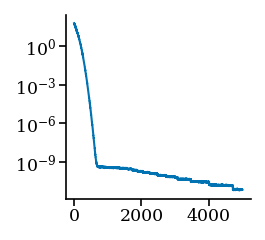

In [6]:
plt.semilogy(loss_history)

In [100]:
phases_history_short = phases_history[::25]
phases_history_short = np.array([model.unit_cell.wrap(phases_history_short[i]) for i in range(len(phases_history_short))])

radius, _ = hex_radius(phases_history[-1],model)
orientation, _ = hex_orientation(phases_history[-1],model)
center = np.mean(phases_history[-1],axis=0)
metagon = Hexagon(radius, orientation, center)
orientation

10.893394649130883

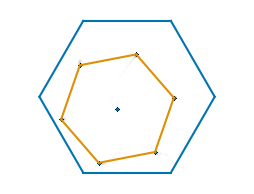

In [101]:
figsize = set_size(fraction=(1/3,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

N = len(phases_history_short)
[ax.scatter(*phases_history_short[i].T,color='black',alpha=(i+0.7)/(N+0.7)) for i in range(N)]
ax.scatter(*phases_history[-1].T)
model.unit_cell.plot(fig,ax,color=color_cycler[0])
metagon.plot(fig,ax,color=color_cycler[1])

ax.axis('off')
ax.axis('equal')
#padding = 0.0
#ax.set_position([-padding, -padding, 1+padding, 1+padding])
fig.tight_layout(pad=0.35, h_pad=0, w_pad=0)

if savefigs:
    fig.savefig('../results/P3-optimal-7phases')

In [9]:
"""
Check symmetry of learned solution to rotation and scale
"""
import copy
center = np.zeros(2)#torch.Tensor([0,0])
standard_metagon = Hexagon(radius, 0, center)
search_model = copy.deepcopy(model)

res=100
scales = np.linspace(0.0, model.unit_cell.radius, num=res)
orientations = np.linspace(0, 30.0, num=res)
mesh = model.unit_cell.mesh(100)
CIness_rm = np.zeros((res,res))

for i in tqdm.trange(len(scales)):
    for j, angle in enumerate(orientations):
        metagon = Hexagon(scales[i], angle, center)
        search_model.set_phases(np.concatenate([metagon.center[None], metagon.hpoints],axis=0))
        CIness_rm[i,j] = search_model.CI_metric(r=torch.tensor(mesh,dtype=torch.float32)).item()

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


In [10]:
"""
Check symmetry of learned solution to translation
"""
CIness_shift = np.zeros(len(mesh))
for i in tqdm.trange(len(mesh)):
    meta_phase = mesh[i]
    optimal_shifted_phases_wrapped = phases_history[-1] + meta_phase #model.unit_cell.wrap(phases_history[-1] + meta_phase)
    model.set_phases(optimal_shifted_phases_wrapped)
    CIness_shift[i] = model.CI_metric(r=torch.tensor(mesh, dtype=dtype)).item()

100%|██████████| 10000/10000 [00:29<00:00, 343.09it/s]


In [11]:
"""
Check symmetry of learned solution to ceteris paribus (all else equal)
"""
CIness_cp = np.zeros(len(mesh))
new_phases = phases_history[-1].copy()
for i in tqdm.trange(len(mesh)):
    new_phases[0] = mesh[i]
    model.set_phases(new_phases)
    CIness_cp[i] = model.CI_metric(r=torch.tensor(mesh, dtype=dtype)).item()

100%|██████████| 10000/10000 [00:30<00:00, 327.76it/s]


In [12]:
vmin = np.min(np.log(CIness_rm)), np.min(np.log(CIness_shift)), np.min(np.log(CIness_cp))
vmax = np.max(np.log(CIness_rm)), np.max(np.log(CIness_shift)), np.max(np.log(CIness_cp))
vmin,vmax

((-4.640255664162098, -25.835098463383172, -3.8018511117360596),
 (6.597600739083762, -24.66982701984724, 3.6702231498240563))

In [13]:
vmin, vmax = np.min(np.log(CIness_rm)), np.max(np.log(CIness_rm))

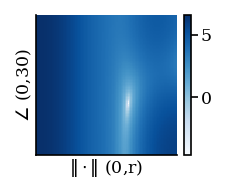

In [92]:
fig, ax = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))
im = ax.imshow(np.log(CIness_rm).T, origin = 'lower', vmin=vmin, vmax=vmax,)

# set ticks for min and max values
idx = np.unravel_index(np.argmin(CIness_rm), CIness_rm.shape)
# add min and max ticks
fractions = np.linspace(0,1,2)
xticks = (CIness_rm.shape[0] - 1)*fractions
yticks = (CIness_rm.shape[1] - 1)*fractions
# add min and max value ticks
xticks = np.append(xticks, idx[0])
yticks = np.append(yticks, idx[1])
# sort ticks
xticks = np.sort(xticks).astype(int)
xticks = xticks[:-1]
yticks = np.sort(yticks).astype(int)
# add corresponding tick labels
xticklabels = np.around(scales[xticks],decimals=2)
yticklabels = np.around(orientations[yticks],decimals=1)
# set ticks
#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(xticklabels)
#ax.set_yticklabels(yticklabels)

#ax.set_xlabel('magnitude')
#ax.set_ylabel('orientation')
ax.set_xlabel(r'$\| \cdot \|$ ' + r'(0,r)', fontsize='small')
ax.set_ylabel(r'$\angle$ ' + r'(0,30)', fontsize='small')
colorbar_axis(fig, ax, im)
#ax.set_position([0.23, 0.28, 0.75, 0.68])
#plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-CI_metric_rm')

In [64]:
savefigs = True

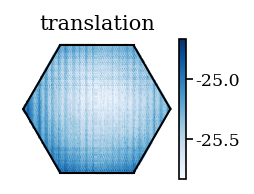

In [78]:
fig, ax = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))
#im = ax.scatter(*mesh.T,c=np.log(CIness_shift),vmin=np.min(np.log(CIness_rm)),vmax=np.max(np.log(CIness_rm)))#,cmap='coolwarm')
im = ax.scatter(*mesh.T,c=np.log(CIness_shift))#, vmin=vmin, vmax=vmax) 
#im = ax.scatter(*mesh.T,c=CIness_shift) 
model.unit_cell.plot(fig,ax,color='black')
ax.axis('off')
ax.axis('equal')
ax.set_title('translation', fontsize='medium')

padding = 0.0
#ax.set_position([0,0,1,0.84]) # make room for title
ax.patch.set_alpha(0)
#colorbar_axis(fig, ax, im)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0)
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-CI_shift_symmetry')

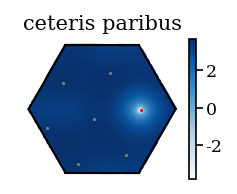

In [82]:
fig, ax = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))
#im = ax.scatter(*mesh.T,c=np.log(CIness_cp),vmin=np.min(np.log(CIness_rm)),vmax=np.max(np.log(CIness_rm)))#,cmap='coolwarm')
im = ax.scatter(*mesh.T,c=np.log(CIness_cp))#, vmin=vmin, vmax=vmax)
ax.scatter(*phases_history[-1][1:].T, color='grey')
ax.scatter(*phases_history[-1][:1].T, color='red')
model.unit_cell.plot(fig,ax,color='black')
ax.axis('off')
ax.axis('equal')
ax.set_title('ceteris paribus', fontsize='medium')

padding = 0.0
#ax.set_position([0,0,1,0.84]) # make room for title
ax.patch.set_alpha(0)
#colorbar_axis(fig, ax, im)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0)
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-CI_cp_symmetry')

In [17]:
radius = model.unit_cell.radius
# 4 points of a square defining the edges of the unit cell in rhombus basis
coords = np.array([
    [-radius * 3 / 4, -radius * 3 / 4],
    [radius * 3 / 4, -radius * 3 / 4],
    [radius * 3 / 4, radius * 3 / 4],
    [-radius * 3 / 4, radius * 3 / 4],
])

from utils import rhombus_transform
#rhombus_coords = rhombus_transform(coords, theta=-60, degrees=True)
rhombus_coords = rhombus_transform(coords, theta=60, degrees=True)

centered_solution = phases_history[-1] - np.mean(phases_history[-1], axis=0)
#centered_solution = centered_solution @ rotation_matrix(-orientation, degrees=True).T

(array([0, 1, 2, 3, 4, 5, 6]), array([1425, 1430, 1432, 1429, 1421, 1431, 1432]))


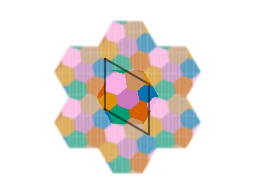

In [102]:
fig,ax  = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))#,dpi=300)
# SPATIAL VORONOI
voronoi_dists = np.stack([model.unit_cell.geodesic(mesh,centered_solution[i:i+1]) for i in range(len(model.phases))])
vd_idxs = np.argmin(voronoi_dists,axis=0)
[ax.scatter(*mesh[vd_idxs==i].T, color=color_cycler[i]) for i in range(len(model.phases))]
for basis in model.unit_cell.basis:
    [ax.scatter(*(mesh[vd_idxs==i] - 2*basis).T, color=color_cycler[i], alpha=0.025) for i in range(len(model.phases))];

ax.plot(*rhombus_coords.T, color='black', alpha=0.5)#, linewidth=0.5)
ax.plot(*rhombus_coords[[0,-1]].T, color='black', alpha=0.5)#, linewidth=0.5)
ax.axis('equal')
ax.axis('off')
padding = 0.0
#ax.set_position([-padding, -padding, 1+padding, 1+padding])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)
print(np.unique(vd_idxs, return_counts=True))

if savefigs:
    fig.savefig('../results/P3-CI_voronoi')

In [19]:
projection = umap.UMAP(n_neighbors=1000,n_components=3)
activity = model(torch.tensor(mesh, dtype=dtype)).detach().numpy()
manifold = projection.fit_transform(activity)
# normalize to [0,1]
#manifold -= np.min(manifold,axis=0)
#manifold /= np.max(manifold,axis=0)

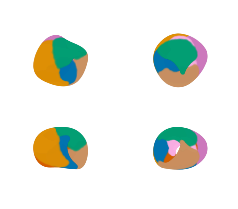

In [20]:
# SAME TORUS MULTIPLE VIEW ANGLES

figsize = set_size(fraction=(1/3,1/4),mode='square')
nrows, ncols = 2, 2
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,subplot_kw={"projection": "3d"},figsize=figsize)#, dpi=300)

azims = np.linspace(0, 180, ncols + 1)[:-1]
elevs = np.linspace(0, 90, nrows + 1)[:-1]
view_angles = np.stack(np.meshgrid(azims, elevs), axis=-1)
grid = np.meshgrid(np.linspace(0,1,nrows,endpoint=False), np.linspace(0,1,ncols,endpoint=False))
grid = np.stack(grid, axis=-1)
padding = 0#-0.1
for i in range(nrows):
    for j in range(ncols):
        for k in np.unique(vd_idxs):
            axs[i,j].scatter(*manifold[vd_idxs==k].T, c=color_cycler[k], s=1, alpha=0.25)
        axs[i,j].azim = view_angles[i, j, 0]
        axs[i,j].elev = view_angles[i, j, 1]
        axs[i,j].axis("off")
        axs[i,j].set_position([*grid[i,j], 1/ncols-padding, 1/nrows-padding])
        axs[i,j].patch.set_alpha(0)

20 40 50


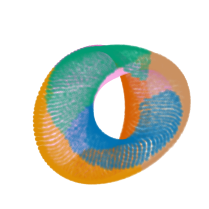

In [42]:
# ONE TORUS

figsize = set_size(fraction=(1/3,1/4),mode='square')
fig,ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=figsize)#, dpi=300)
if True:
    elev=np.random.uniform(0,90)
    azim=np.random.uniform(0,180)
    roll=np.random.uniform(0,360)
#elev, azim, roll = 29.36979484777273, 135.64536544454165, 92.62591251255421
elev, azim, roll = 20,40,50
ax.view_init(elev=elev, azim=azim, roll=roll)
print(ax.elev, ax.azim, ax.roll)

for k in np.unique(vd_idxs):
    ax.scatter(*manifold[vd_idxs==k].T, c=color_cycler[k], s=1, alpha=0.25)
ax.axis("off")
ax.axis("equal")
# set axes limits to fraction of the data range
fraction = -0.15
ax.set_xlim(manifold[:,0].min() - fraction * (manifold[:,0].max() - manifold[:,0].min()), manifold[:,0].max() + fraction * (manifold[:,0].max() - manifold[:,0].min()))
ax.set_ylim(manifold[:,1].min() - fraction * (manifold[:,1].max() - manifold[:,1].min()), manifold[:,1].max() + fraction * (manifold[:,1].max() - manifold[:,1].min()))
ax.set_zlim(manifold[:,2].min() - fraction * (manifold[:,2].max() - manifold[:,2].min()), manifold[:,2].max() + fraction * (manifold[:,2].max() - manifold[:,2].min()))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

if savefigs:
    fig.savefig('../results/P3-CI_torus')

In [22]:
def max_birth_max_death(dgmss):
    flat_dgmss = []
    for dgms in dgmss:
        flat_dgmss += dgms
    flat_x_dgms = np.concatenate([dgms[i][:,0] for i in range(len(dgms))])
    flat_y_dgms = np.concatenate([dgms[i][:,1] for i in range(len(dgms))])
    return np.max(flat_x_dgms), np.max(np.ma.masked_invalid(flat_y_dgms))

def ripsers(axs, dgmss,xmargin=1.3,ymargin=1.2):
    xmax, ymax = max_birth_max_death(dgmss)
    for i in range(len(axs)):
        axs[i].plot(np.linspace(0,xmax*xmargin,2),np.linspace(0,xmax*xmargin,2),
                    linewidth=0.4,color='grey')#,ls=':')    
        axs[i].set_xlim([-0.1,xmax*xmargin])
        axs[i].set_ylim([-0.1,ymax*ymargin])
        axs[i].set_xticks([0,round(xmax)])
        axs[i].set_yticks([0,round(ymax)])
        axs[i].xaxis.tick_top()
        axs[i].spines['top'].set_visible(True)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].patch.set_alpha(0)
        if i > 0:
            #axs[i].set_yticks([])
            axs[i].axis('off')
        for b,cocycle in enumerate(dgmss[i]):
            if b==0:
                cocycle = np.append(cocycle,np.array([[0,ymax*(ymargin-0.05)]]),axis=0)
            axs[i].scatter(*cocycle.T,s=5)

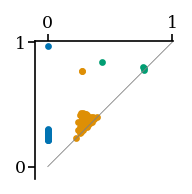

In [80]:
dgms = ripser(activity,maxdim=2,n_perm=150)['dgms']

fig,ax = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))#,dpi=300)
ripsers([ax],[dgms])
#ax.set_position([0.1,0,1,0.84]) # perfect padding for including ticks and otherwise filling box
ax.set_aspect('equal')
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if True:
    fig.savefig('../results/P3-CI_ripsers')